In [1]:
from community import best_partition, modularity
import numpy as np
import pandas as pd
import networkx as nx
import collections as clt
import matplotlib.pyplot as plt
import pickle
import itertools
from joblib import Parallel, delayed
import math
import time

In [2]:
plt.rcParams["figure.figsize"] = (12,10) #defining size of plots

In [3]:
df = pd.read_csv('reviews_full_v9-2.csv')
df.head()

,User,Date,Year,Month,Release,Band,Score,Link,Album_link,Review_title,...,Band_Genre,Combined_Genre,Key Features,Cleansed Features,Cleansed Text,Product Features,Product Features_dep,neg,neu,pos
0,SpookyApparition,July 11 2002,2002,7,Chaosphere,Meshuggah,82,https://www.metal-archives.com/reviews/Meshugg...,https://www.metal-archives.com/albums/Meshugga...,Technical metal at it's finest.,...,groove metal|thrash metal,technical thrash metal|math metal|progressive ...,originally bought|entire album|sounded variati...,originally bought|entire album|sounded variati...,I originally bought Chaosphere in late 2000......,entire album|sounded variation|grown appreciat...,tacky place|respective instruments|vocal perfo...,0.025,0.826,0.149
1,SpookyApparition,July 14 2002,2002,7,Necroticism_-_Descanting_the_Insalubrious,Carcass,88,https://www.metal-archives.com/reviews/Carcass...,https://www.metal-archives.com/albums/Carcass/...,Carcass at their finest.,...,grindcore|death metal,grindcore|melodic death metal,somewhat song structures|song structures|injec...,somewhat song structures|song structures|injec...,A midpoint between Carcass' early grind albums...,somewhat song structures|song structures|injec...,melodic variety|vocal performances|enjoyable a...,0.038,0.850,0.111
2,MarkRyan,July 15 2002,2002,7,Angels_Fall_First,Nightwish,90,https://www.metal-archives.com/reviews/Nightwi...,https://www.metal-archives.com/albums/Nightwis...,On par with their other stuff...,...,symphonic metal|power metal,symphonic power metal,general consensus|lose credibility|sung poet|b...,general consensus|lose credibility|sung poet|b...,"I'm not hard-core into metal at all, really, b...",general consensus|lose credibility|sung poet|b...,beautiful melody|beautiful example|general con...,0.026,0.771,0.202
3,Fear,July 16 2002,2002,7,Dark_Genesis,Iced_Earth,87,https://www.metal-archives.com/reviews/Iced_Ea...,https://www.metal-archives.com/albums/Iced_Ear...,Brilliance in Repackaging,...,thrash metal|power metal,heavy metal|us power metal,new album fact|old material|bought big fan|big...,new album fact|old material|bought big fan|big...,"This is not a new album, but in fact, five alb...",new album fact|old material|bought big fan|big...,different versions|original vocals|old materia...,0.031,0.723,0.246
4,Esoteric,July 16 2002,2002,7,A_Night_at_the_Opera,Blind_Guardian,70,https://www.metal-archives.com/reviews/Blind_G...,https://www.metal-archives.com/albums/Blind_Gu...,Somewhat Disappointing,...,speed metal|power metal,power metal,accurate description album|vocal lines|meaty a...,accurate description album|vocal lines|meaty a...,I've been trying for months to come up with an...,accurate description album|vocal lines|meaty a...,catchy songs|bad album|vocal lines|little line...,0.130,0.747,0.123


In [4]:
features_freq = pickle.load(open('opinionsv3.p','rb')) 
print(len(features_freq))
genre_group = pickle.load(open('genre_group.p','rb'))

680777


In [5]:
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer() 
def isNaN(x):
    return x != x

def lem(x):
    return ' '.join([lemma.lemmatize(word) for word in x.split()])

0 0.09509992599487305
10000 3.0460965633392334
20000 4.705171823501587
30000 6.479788541793823
40000 8.501492500305176
50000 10.513591051101685
60000 12.57823395729065
70000 14.993970155715942
80000 17.026878595352173
90000 19.031876802444458


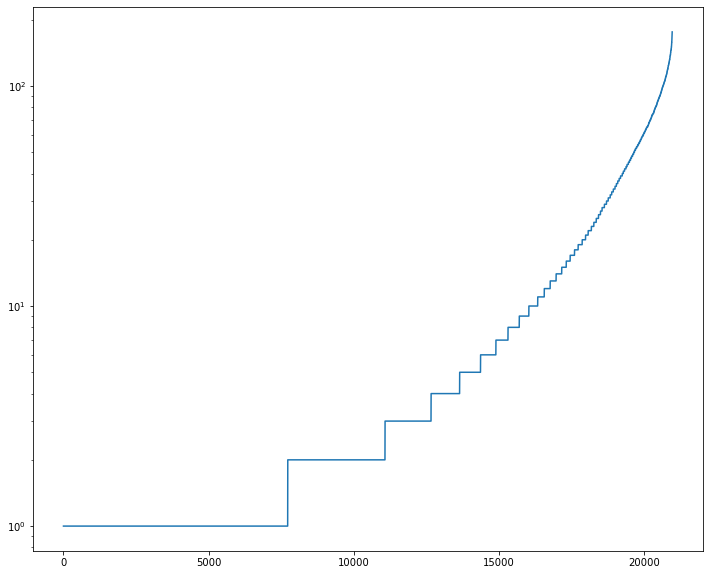

In [6]:
adj_to_genre = {}
t1 = time.time()
all_genres = set()
for i,row in df.iterrows():
    if i%10000 == 0:
        print(i,time.time()-t1)
    if isNaN(row['Product Features_dep']) or isNaN(row['Combined_Genre']):
        continue
    features = row['Product Features_dep'].split('|')
    genres = row['Combined_Genre'].split('|')
    album = row['Release']
    for genre in genres.copy():
        if genre not in genre_group or genre_group[genre] == 'Non-metal' or genre_group[genre] == 'Others':
            genres.remove(genre)
    
    for feature in features:
        adj = lemma.lemmatize(feature.split(' ')[0])
        if adj not in adj_to_genre:
            adj_to_genre[adj] = set()
        for genre in genres:
            adj_to_genre[adj].add(genre)
            all_genres.add(genre)

genfreq = {}
for adj in adj_to_genre:
    if len(adj_to_genre[adj]) != 0:
        genfreq[adj] = len(adj_to_genre[adj])

plt.semilogy(sorted(genfreq.values()))
plt.show()    

In [7]:
cxt_raw = []
genres_all = []
features_all = set()
feat_to_gen = {}
t1 = time.time()
for i,row in df.iterrows():
    if i%10000 == 0:
        print(i,time.time()-t1)
    if isNaN(row['Product Features_dep']) or isNaN(row['Combined_Genre']):
        continue
    featurelist = [feature for feature in row['Product Features_dep'].split('|') if 'metal' not in feature]
    genrelist = [genre for genre in row['Combined_Genre'].split('|') if genre in genre_group and genre_group[genre] != 'Non-metal' and genre_group[genre] != 'Others']
    for genre in genrelist:
        genre += ' (G)'
        for feature in featurelist:
            #if features_freq[feature] > 1:
            if True:
                feature = lem(feature)
                if feature not in feat_to_gen:
                    feat_to_gen[feature] = set()
                feat_to_gen[feature].add(genre)  
                cxt_raw.append((feature, genre))
                features_all.add(feature)
                genres_all.append(genre)
cxt = clt.Counter(cxt_raw)
genres_all = clt.Counter(genres_all)

0 0.10542082786560059
10000 2.743870258331299
20000 5.833054542541504
30000 8.838178396224976
40000 12.35631537437439
50000 15.758102416992188
60000 19.202759742736816
70000 23.286087036132812
80000 26.904913187026978
90000 30.50071930885315


In [8]:
#cxt is term frequency (tf)
idf = {}
for adj in genfreq:
    idf[adj] = math.log(len(all_genres)/genfreq[adj])
tfidf = {}
for feature, genre in cxt:
    adj = feature.split(' ')[0]
    tfidf[(feature,genre)] = cxt[(feature,genre)]*idf[adj]

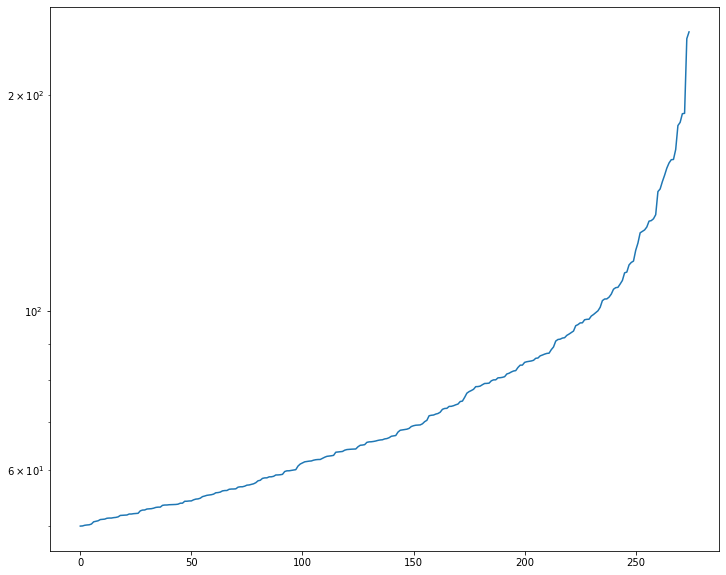

In [9]:
plt.semilogy([x for x in sorted(list(tfidf.values())) if x > 50])
plt.show()

In [10]:
from concepts import Context

In [11]:
thres = 20

genres_final = set(genre for feature, genre in tfidf if tfidf[(feature,genre)] >= thres)
features_final = set(feature for feature, genre in tfidf if tfidf[(feature,genre)] >= thres)
print(len(genres_final), len(features_final))

context_df = pd.DataFrame()
cnt = 0
for genre in genres_final:
    arr = []
    for feature in features_final:
        #if (feature, genre) in cxt and cxt[(feature,genre)]/genres_all[genre] >= 0.05:
        if (feature, genre) in cxt and tfidf[(feature,genre)] >= thres:
            cnt += 1
            arr.append('X')
        else:
            arr.append('')
    context_df[genre] = arr
context_df.index = list(features_final)
context_df.to_csv('fca.csv')
print(cnt)
context_df

38 900
1842


,death doom metal (G),death metal (G),gothic doom metal (G),brutal deathcore (G),progressive metal (G),symphonic black metal (G),teutonic thrash metal (G),folk doom metal (G),thrash metal (G),gothic metal (G),...,neofolk (G),funeral doom metal (G),industrial black metal (G),sludge metal (G),us power metal (G),symphonic power metal (G),symphonic metal (G),folk metal (G),melodic death metal (G),doom metal (G)
abrupt change,,,,,,,,,,,...,,,,,,,,,,
thrash scene,,,,,,,,,X,,...,,,,,,,,,,
slower song,,,,,,,,,X,,...,,,,,,,,,,
weakest track,,,,,,,,,,,...,,,,,,,,,,
second wave,,,,,,,,,,,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
earlier material,,X,,,,,,,,,...,,,,,,,,,,
particular style,,,,,,,,,,,...,,,,,,,,,,
good thing,,X,,,,,,,,,...,,,,,,,,,,
technical riff,,X,,,,,,,X,,...,,,,,,,,,,


In [12]:
c = Context.fromfile('fca.csv', frmat = 'csv')
l = c.lattice

In [13]:
x,y = l[90]
x,y,len(l)

(('entire album',
  'operatic vocal',
  'slow riff',
  'funeral doom',
  'heavy riff',
  'acoustic guitar',
  'lyrical theme',
  'fuzzy guitar',
  'little bit',
  'double bass',
  'subject matter',
  'foulest semen',
  'female vocalist',
  '21st century',
  'rhythm guitar',
  'favorite track',
  'low end',
  'main riff',
  'lead guitar',
  'distorted guitar',
  'sub genre',
  'long time',
  'serial killer',
  'clean vocal',
  'rhythm section',
  'previous album',
  'harsh vocal',
  'female vocal'),
 ('black metal (G)', 'doom metal (G)'),
 128)

In [14]:
B = nx.Graph()
all_genres = set()
for i,cncpt in enumerate(l):
    features, genres = cncpt
    for genre in genres:
        genre = genre[:-4]
        B.add_edge(genre, i)
        all_genres.add(genre)

G = nx.Graph()
for genre1 in all_genres:
    for features in B.adj[genre1]:
        for genre2 in B.adj[features]:
            if genre2 >= genre1:
                continue
            if G.has_edge(genre1,genre2):
                G[genre1][genre2]['weight'] += 1
            else:
                G.add_edge(genre1, genre2, weight = 1)

G.number_of_nodes(), G.number_of_edges()

(38, 703)

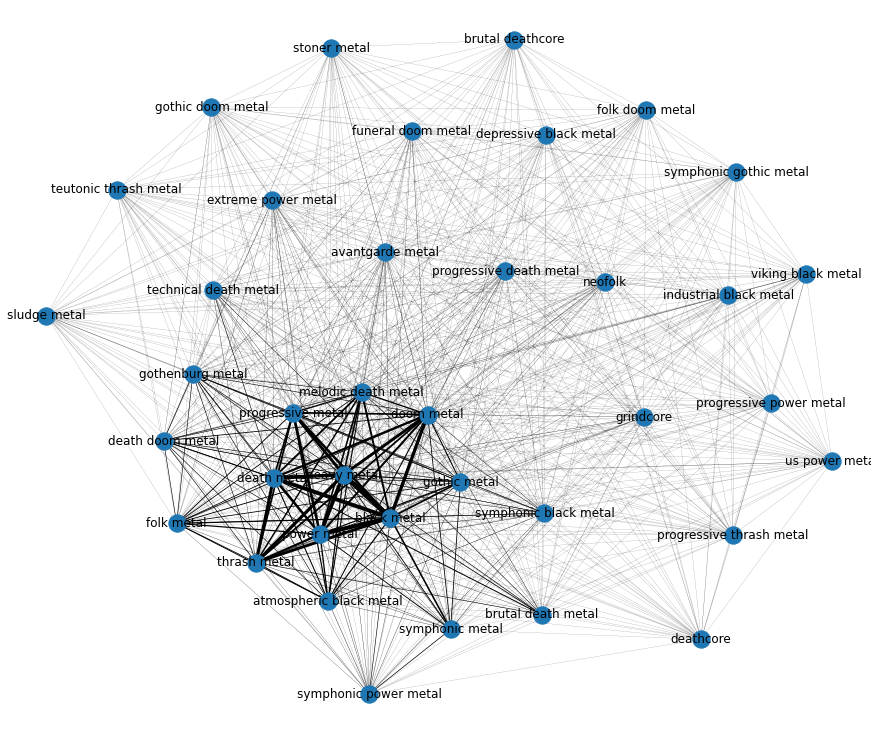

In [15]:
nx.draw(G, width = 0.1*np.array(list(nx.get_edge_attributes(G,'weight').values())), with_labels = True)

In [16]:
G.nodes()

NodeView(('symphonic black metal', 'death doom metal', 'death metal', 'gothic doom metal', 'brutal deathcore', 'progressive metal', 'folk doom metal', 'gothic metal', 'deathcore', 'progressive power metal', 'progressive thrash metal', 'heavy metal', 'avantgarde metal', 'extreme power metal', 'black metal', 'depressive black metal', 'grindcore', 'gothenburg metal', 'power metal', 'progressive death metal', 'stoner metal', 'atmospheric black metal', 'brutal death metal', 'neofolk', 'funeral doom metal', 'industrial black metal', 'sludge metal', 'folk metal', 'melodic death metal', 'doom metal', 'symphonic power metal', 'symphonic gothic metal', 'symphonic metal', 'viking black metal', 'teutonic thrash metal', 'thrash metal', 'technical death metal', 'us power metal'))

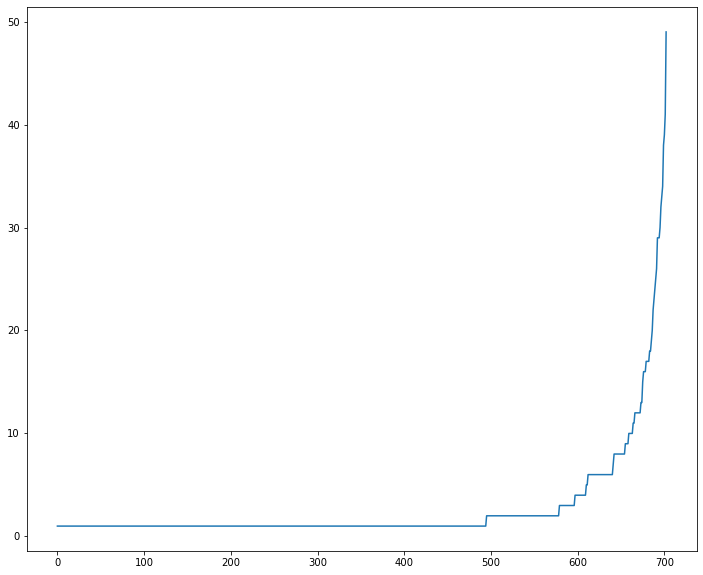

In [17]:
plt.plot(sorted(nx.get_edge_attributes(G,'weight').values()))
plt.show()

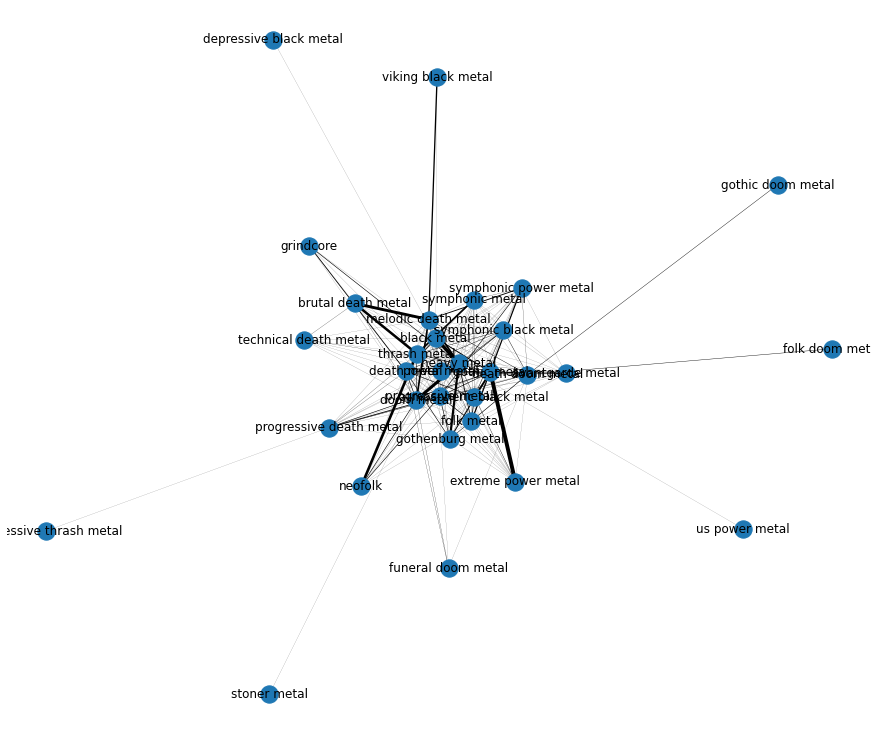

In [18]:
G1 = G.copy()
for u,v in G.edges():
    if G[u][v]['weight'] <= 1:
        G1.remove_edge(u,v)
G1.remove_nodes_from(list(nx.isolates(G1)))
nx.draw(G1, width = 0.1*np.array(list(nx.get_edge_attributes(G,'weight').values())), with_labels = True)